Step 01: Correct beads signal median
-------

\begin{align}
 S_{p, i} &= \left( \text{Median}_{bead, i} - \text{Median}_{back.} \right)\\[20pt]
 \text{rCV}_{corr, i} &= \frac{\text{rSD}_{bead, i}}{S_{p, i}}
\end{align}


Step 02: Isolate the photon‑noise CV
-------

\begin{align}
 \text{CV}_{p, phot, i} = \sqrt{\left( \text{rCV}_{corr, i} \right)^2 - \left( \text{rCV}_{bright} \right)^2}
\end{align}

Step 03: Fit J
-------

\begin{align}
 \text{CV}_{p, phot, i} = \frac{J}{\sqrt{S_{p, i}}}
\end{align}

Step 04: Fit K
-------

\begin{align}
 \sigma_{s, i} = K S_{p, i}
\end{align}

Imports
-------

In [1]:
# %matplotlib inline
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FlowCyPy import units
from FlowCyPy import NoiseSetting
from FlowCyPy.dev import get_scatterer_metrics, get_trigger_metrics, get_acquisition_analog_metrics, get_acquisition_digital_metrics, get_trigger_signals, plot_with_fit
from FlowCyPy import circuits
from MPSPlots.styles import mps

Settings
--------

In [2]:
NoiseSetting.include_noises = True
NoiseSetting.include_shot_noise = True
NoiseSetting.include_amplifier_noise = False
NoiseSetting.include_source_noise = False
NoiseSetting.include_dark_current_noise = False

NoiseSetting.assume_perfect_hydrodynamic_focusing = True

kwargs = dict(
    bit_depth='25bit',
    saturation_levels = (0 * units.volt, 5 * units.volt),
    processing_steps=[],
    background_fraction=0.0001,
    particle_count=100,
    optical_power=100 * units.milliwatt,
    run_time = 6 * units.millisecond
)

In [ ]:
plt.close('all')
N_elements = 15
diameter_list = np.linspace(300, 1200, N_elements) * units.nanometer
index_list = np.ones(N_elements) * 1.44 * units.RIU

beads_df = get_trigger_signals(
    diameter_list=diameter_list[:],
    index_list=index_list[:],
    threshold='4 sigma',
    **kwargs,
    # plot_analog=True,
    # plot_trigger=True
)

background_df = get_acquisition_digital_metrics(
    diameter_list=[None],
    index_list=[None],
    **kwargs,
)

Simulating configuration Delta(position=300.000 nm), background_power = 0.01 mW, optical_power = 100 mW, run_time = 6 ms, bit_depth = '25bit', saturation_levels = (<Quantity(0, 'volt')>, <Quantity(5, 'volt')>)
Simulating configuration Delta(position=364.286 nm), background_power = 0.01 mW, optical_power = 100 mW, run_time = 6 ms, bit_depth = '25bit', saturation_levels = (<Quantity(0, 'volt')>, <Quantity(5, 'volt')>)
Simulating configuration Delta(position=428.571 nm), background_power = 0.01 mW, optical_power = 100 mW, run_time = 6 ms, bit_depth = '25bit', saturation_levels = (<Quantity(0, 'volt')>, <Quantity(5, 'volt')>)
Simulating configuration Delta(position=492.857 nm), background_power = 0.01 mW, optical_power = 100 mW, run_time = 6 ms, bit_depth = '25bit', saturation_levels = (<Quantity(0, 'volt')>, <Quantity(5, 'volt')>)
Simulating configuration Delta(position=557.143 nm), background_power = 0.01 mW, optical_power = 100 mW, run_time = 6 ms, bit_depth = '25bit', saturation_levels

In [ ]:
def get_rSD(array):
    return (np.percentile(array, 84.13) - np.percentile(array, 15.87) ) / 2

optical_power = 100
background_power = 0.01

background_median = background_df[background_df.BackgroundPower == background_power]['Median'].values[0]

S_measured = beads_df['Height'].to_frame()

S_corrected = S_measured - background_median

metrics = pd.DataFrame().astype(float)

metrics['Csca'] = beads_df['Csca'].groupby('Diameter').mean()
metrics['DetectorPower'] = beads_df['DetectorPower'].groupby('Diameter').mean()

metrics['rSD'] = S_corrected.groupby('Diameter').apply(get_rSD)

metrics['Median'] = S_corrected.groupby('Diameter').apply('median')

metrics['rCV'] = metrics['rSD'] / metrics['Median']

metrics = metrics.astype(float)
metrics['InvSqrtMedian'] = 1 / (np.sqrt(metrics['Median'].values))

metrics = metrics.reset_index()

In [ ]:
from MPSPlots.styles import mps


with plt.style.context(mps):
    figure, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    _, J = plot_with_fit(
        ax=ax[0],
        x=metrics['InvSqrtMedian'],
        y=metrics['rCV'],
        degrees=[1],
        strict_degree=True,
        ylabel='Robust coeffcicient of variation',
        xlabel=r'(Median)$^{-0.5}$'
    )
    
    
    _, K = plot_with_fit(
        ax=ax[1],
        x=metrics['Median'],
        y=metrics['Csca'],
        degrees=[1],
        strict_degree=True,
        ylabel='Signal Median',
        xlabel=r'Scattering cross-section [nm$^2$]'
    )

Q = 1 / (K * J * J)

Q

$$
    S_p = \text{Median}_{bead} - \text{Median}_{back}
$$

$$
  \text{rSD} = \frac{P_{84.13} - P_{15.87}}{2}
$$

In [97]:
from FlowCyPy.physical_constant import PhysicalConstant

diameter = diameter_list[0].magnitude

P_det = beads_df.loc[(diameter, 0), 'DetectorPower'] * units.milliwatt
Csca = beads_df.loc[(diameter, 0), 'Csca'] * units.nanometer ** 2


responsivity = 1 * units.ampere / units.watt
sampling_rate = 60 * units.megahertz
dt = 1 / sampling_rate


N_pe = (responsivity * P_det * dt / PhysicalConstant.e).to('dimensionless')
Q_ = N_pe / Csca
Q_

<Quantity(4883.33739, '1 / nanometer ** 2')>

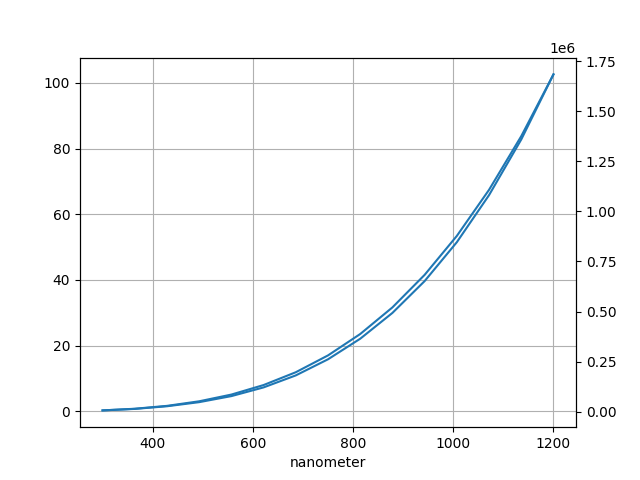

In [26]:
figure, ax = plt.subplots(1, 1)
_df = beads_df.groupby('Diameter').mean()

x = _df['DetectorPower'].values
y = _df['Csca'].values

ax.plot(diameter_list, x)

twin_ax = ax.twinx()
twin_ax.plot(diameter_list, y)

# ax.set_aspect('equal')
ax.grid()
plt.show()

Height          Csca  DetectorPower
Diameter SegmentID                                        
300.0    0            20662.0  6.343993e+03       0.297811
         1            20658.0  6.343993e+03       0.297811
         2            20654.0  6.343993e+03       0.297811
         3            20659.0  6.343993e+03       0.297811
         4            20657.0  6.343993e+03       0.297811
...                       ...           ...            ...
1200.0   95         6883247.0  1.683480e+06     102.561788
         96         6883340.0  1.683480e+06     102.561788
         97         6883163.0  1.683480e+06     102.561788
         98         6883289.0  1.683480e+06     102.561788
         99         6883186.0  1.683480e+06     102.561788

[1411 rows x 3 columns]